<a href="https://colab.research.google.com/github/touseefashraf/DL_course/blob/main/Copy_of_DL_Lab_1.2_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL Lab 1.2 - Homework - Implementing a Multi-layer Perceptron in NumPy

In this notebook you will implement a small Multi-layer Perceptron (MLP) to distinguish images of flowers from images of leaves. Your MLP will have two layers, and you will be using NumPy for the implementation.

***

**After completing this homework you will**

- Be able to implement **dense** and **sigmoid activation** layers
- Be able to design **neural network architectures** containing dense layers and sigmoid activation
- Be able to **forward** images through your neural network
- Be able to compute the **binary cross-entropy loss** for measuring the network's prediction error
- Be able to perform **backpropagation** using the chain rule

***

**Instructions**

- You'll be using Python 3 in the iPython based Google Colaboratory
- Lines encapsulated in "<font color='green'>`### START YOUR CODE HERE ###`</font>" and "<font color='green'>`### END YOUR CODE HERE ###`</font>", or marked by "<font color='green'>`# TODO`</font>", denote the code fragments to be completed by you.
- There's no need to write any other code.
- After writing your code, you can run the cell by either pressing `SHIFT`+`ENTER` or by clicking on the play symbol on the left side of the cell.
- We may specify "<font color='green'>`(≈ X LOC)`</font>" in the "<font color='green'>`# TODO`</font>" comments to tell you about how many lines of code you need to write. This is just a rough estimate, so don't feel bad if your code is longer or shorter.
- If you get stuck, check your Lecture and Lab notes and use the [discussion forum](https://moodle2.tu-ilmenau.de/mod/forum/view.php?id=4466) in Moodle.

Let's get started!

***

<font color='darkblue'> 
**Remember**  
- Run your cells using SHIFT + ENTER (or "Run cell")
- Write code in the designated areas using Python 3 only
- Do not modify the code outside of the designated areas
</font>

## 0 - Packages
At first, let's import the packages we will need today:

- [numpy](www.numpy.org) remember our first lab: NumPy is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library for plotting graphs in Python.

In [157]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

BTW: Line numbers can be enabled by pressing `CTRL`+`M`+`L`.

## 1 - Obtaining the Image Dataset

Execute the code below for downloading the dataset and some utility code:

In [158]:
#@title Download dataset and `utils`
archive = 'Lab1.1.zip'
!wget -nv -t 0 --show-progress -O $archive 'https://cloud.tu-ilmenau.de/s/7R3CiEaGdL9KzkB/download'
!unzip -j $archive

Lab1.1.zip              [         <=>        ]  39.86M  20.8MB/s    in 1.9s    
2022-10-22 14:27:53 URL:https://cloud.tu-ilmenau.de/s/7R3CiEaGdL9KzkB/download [41797491] -> "Lab1.1.zip" [1]
Archive:  Lab1.1.zip
replace binary_flowers.npz? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: binary_flowers.npz      
 extracting: utils.py                


The dataset is provided as archive of numpy arrays, each stored as binary file. We'll unpack them to `X_train, Y_train, X_validation, Y_validation`:

In [159]:
import utils

X_train, Y_train, X_validation, Y_validation = utils.load_npz_dataset('binary_flowers.npz')

Let's plot some images to get an idea about the task:

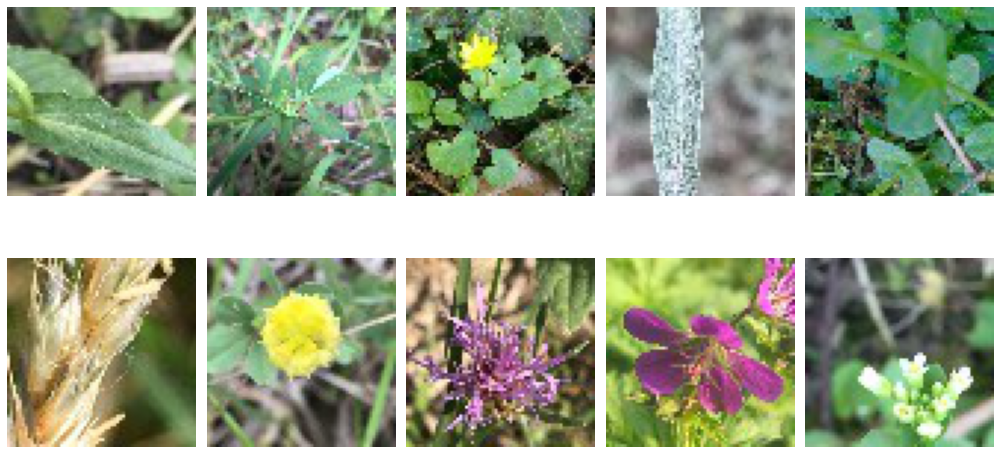

In [160]:
utils.plot_samples(X_validation, Y_validation)

The first row displays images of leaves. We will use them as **negative class** (`y=0`). 

The second row displays images of flowers. They will constitute our **positive class** (`y=1`). 
Note that the flowers of weeds are quite hard to distinguish from leaves.

**Exercise**: What is the shape of the NumPy arrays `X_validation` and `Y_validation`? How many training samples do you have?

**Task**: Print the shape of the arrays `X_validation` and `Y_validation` and state the number of training samples.

In [161]:
# GRADED: print the shape of `X_validation` (.5 points)
# GRADED: print the shape of `Y_validation` (.5 points)
# GRADED: state the number of training samples (.5 points)

### START YOUR CODE HERE ### (≈ 3 LOC)
print(X_validation.shape)
print(Y_validation.shape)
print(f'Number of training samples are {X_validation.shape[3]} ')


### END YOUR CODE HERE ###

(64, 64, 3, 200)
(200,)
Number of training samples are 200 


### Vectorization over Training Examples

In order to vectorize our code, we have to reshape our image arrays of shape `(width, height, channels, num_samples)` to arrays of shape `(num_features, num_samples)`

**Task**: Reshape the training and test data. Evaluate your result by plotting the first training sample. For plotting, the utility code reshapes your images. 
**Make sure the plotted images do not display garbage.**

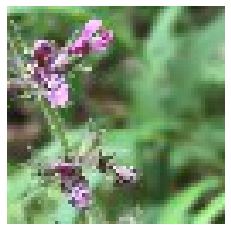

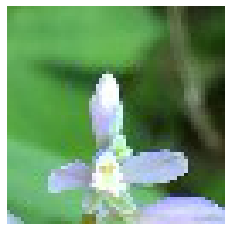

In [162]:
# GRADED FUNCTION: flatten_images (1 point)

def flatten_images(X):
  """Reshape images array `X` to array of shape `(num_features, num_samples)`.

  Args:
    X (numpy.ndarray): images array, shape = `(width, height, channels, num_samples)`

  Returns:
    numpy.ndarray: array of shape `(num_features, num_samples)`
  """
  utils.flatten_images.assert_input_shape(X)
  
  ### START YOUR CODE HERE ### (≈ 1 LOC)
  X=X.reshape(X.shape[0]*X.shape[1]*X.shape[2],X.shape[3])

  ### END YOUR CODE HERE ###
  
  utils.flatten_images.assert_output_shape(X)
  return X


# reshape `X_train` to (num_features, num_samples)
X_train = flatten_images(X_train)
utils.plot_sample(X_train)

# reshape `X_validation` to (num_features, num_samples)
X_validation = flatten_images(X_validation)
utils.plot_sample(X_validation)

## 2 - Implement Layers and Loss function

Our network will contain dense layers and sigmoid activation layers. We objectify these layers for making the forward and backward computations easier. In detail, each layer class will have a `forward` and `backward` method that are callable on arbitrary inputs of defined shape.

**Task**: Complete the `forward`, `backward`, and `update` methods of the `Dense` class.

In [163]:
# GRADED FUNCTION: Dense.forward (1 point)
# GRADED FUNCTION: Dense.backward (1 point)
# GRADED FUNCTION: Dense.update (1 point)

class Dense:
  """ Dense layer with weight matrix `W` and bias vector `b`.
  
  Attributes:
  ---
    num_neurons (int): number of neurons (equals the output size)
    input_shape (tuple): shape of the input data
    W (numpy.ndarray): layer weights
    b (numpy.ndarray): layer bias
    input (numpy.ndarray): layer input
    output (numpy.ndarray): layer output
    dW (numpy.ndarray): derivative w.r.t. weights `W`
    db (numpy.ndarray): derivative w.r.t. bias `b`
    gradient_out (numpy.ndarray): derivative w.r.t. layer input `input`
  
  Methods:
  ---
    forward( input )
    backward( gradient_in )
    update()
  """

  def __init__(self, num_neurons, input_shape):
    """Init a dense layer

    Initialize a dense layer with number of neurons = `neurons` for an input of 
    shape `input_shape`.
    Weights `W` are randomly initialized from normal distribution. Bias `b` is 
    initialized as zeros.

    Args:
        num_neurons (int): number of neurons in layer; equal to output dimension of layer
        input_shape (tuple): shape of input data `(num_features, num_samples)`
    """

    self.input_shape = input_shape
    self.num_neurons = num_neurons

    # initialize with normal distributed random weights
    self.W = np.random.normal( scale=.1, size=(self.num_neurons, self.input_shape[0]))
    self.b = np.zeros( (self.num_neurons, 1) )

    # allocate output (neurons, m)
    self.output = np.zeros( (self.num_neurons, self.input_shape[1]))


  def forward(self, input):
    """ Forward pass of `input` through dense layer. Output is stored in `output`.

    Args:
      input (numpy.ndarray): layer input
    """
    
    # store layer input
    self.input = input
    
    # compute layer output
    ### START YOUR CODE HERE ### (≈ 1 LOC)
    self.output=np.dot(self.W,self.input)+self.b
    ### END YOUR CODE HERE ###


  def backward(self, gradient_in):
    """ Backward pass of `gradient_in` through dense layer. 
    Computes derivatives (gradients) w.r.t. weights, bias, and layer input.
    Gradients are stored in `dW`, `db`, `gradient_out`.

    Args:
      gradient_in (numpy.ndarray): derivative w.r.t. layer output
    """

    # derivative w.r.t. `W`
    ### START YOUR CODE HERE ### (≈ 1 LOC)
    self.dW=np.dot(gradient_in,self.input.T)
    ### END YOUR CODE HERE ###

    # derivative w.r.t. `b`
    self.db = np.sum(gradient_in, axis=1, keepdims=True)

    # derivative w.r.t. layer input
    self.gradient_out = np.dot(self.W.T, gradient_in)


  def update(self):
    """ Update layer parameters `W`, `b` using global `LEARNING_RATE` """
    
    ### START YOUR CODE HERE ### (≈ 2 LOC)
    self.W=self.W-LEARNING_RATE*self.dW
    self.b=self.b-LEARNING_RATE*self.db
    ### END YOUR CODE HERE ###


  @property
  def number_of_parameters(self):
    if not hasattr(self, '_number_of_parameters'):
      self._number_of_parameters = np.sum(
          [getattr(self, parameter_type).size for parameter_type in ('W', 'b')]
      )
    return self._number_of_parameters

Same as for the `Dense` layer, we will implement the activation function as a **layer**, also with a `forward` and a `backward` method.

**Task**: Complete the class `Sigmoid` by implementing the `forward` and `backward` method.

In [164]:
# GRADED FUNCTION: Sigmoid.forward (1 point)
# GRADED FUNCTION: Sigmoid.backward (1 point)

class Sigmoid:
  """ Activation layer using the logistic function (aka sigmoid function)
  
  Attributes:
  ---
    output (numpy.ndarray): layer output
    gradient_out (numpy.ndarray): derivative w.r.t. layer input `Z`
  
  Methods:
  ---
    forward( input )
    backward( gradient_in )
  """

  def __init__(self, input_shape):
    """Init an activation layer using the Sigmoid activation function.

    Initialize an activation layer for element-wise calculation of the sigmoid
    of a given input of shape `input_shape`.

    Args:
      input_shape (tuple): shape of input data `(num_features, num_samples)`
    """

    # allocate output
    self.output = np.zeros( input_shape )

  def forward(self, input):
    """Forward pass of `input` through sigmoid layer. 
    
    Compute the value of the sigmoid function for each element of `input`.
    The output is stored in `output`.

    Args:
        input (numpy.ndarray): layer input
    """
    ### START YOUR CODE HERE ### (≈ 1 LOC)
    self.output=1 / (1 + np.exp(-input))
    ### END YOUR CODE HERE ###

  def backward(self, gradient_in):
    """Backward pass of `gradient_in` through sigmoid layer. 
    The output is stored in `gradient_out`.

    Args:
        gradient (numpy.ndarray): gradient w.r.t. to layer input
    """
    ### START YOUR CODE HERE ### (≈ 1 LOC)
    self.gradient_out = gradient_in*self.output*(1-self.output)
    ### END YOUR CODE HERE ###

At last, we'll need a loss function to compute the mismatch between model prediction and ground truth. As we are solving a binary classification task, we'll use the **binary cross-entropy loss** defined for one sample as

$l(y, \hat{y}) = -y \log (\hat{y}) - (1-y) \log (1-\hat{y})$.

To assess our model's performance, the function `binary_cross_entropy_loss` shall return the **average loss** across all $m_\mathrm{batch}$ samples in a minibatch:

$\mathcal{L} = \frac{1}{m_\mathrm{batch}}\sum_{i=1}^{m_\mathrm{batch}} l(y, \hat{y})$.


**Task**: Implement the binary cross-entropy loss `loss` and its derivative w.r.t. the model predictions `dY_hat`.

In [165]:
# GRADED FUNCTION: binary_cross_entropy_loss (2 points)

def binary_cross_entropy_loss(Y, Y_hat):
  """Compute binary cross-entropy loss across predictions `Y_hat` and its gradient w.r.t. `Y_hat`.

  Args:
    Y (numpy.ndarray): Ground truth data labels (expected output)
    Y_hat (numpy.ndarray): Predicted labels (output of last layer)

  Returns:
    loss (numpy.float64) : average value of the binary cross-entropy loss
    dY_hat (numpy.ndarray): gradient of loss w.r.t. Y_hat
  """
  # prevent log(0)
  Y_hat += 1e-9

  ### START YOUR CODE HERE ###  (≈2 LOC)
  loss =(1/BATCHSIZE)* (-Y*np.log(Y_hat))-((1-Y)*np.log(1-Y_hat))
  dY_hat =(Y_hat-Y)/Y_hat*(1-Y_hat)
  ### END YOUR CODE HERE ###

  return loss, dY_hat

## 3 - Implementing a 2 Layer Neural Network

Using the layers and the loss function defined above, we can now implement our neural network.

In [166]:
# GRADED FUNCTION: NeuralNet.forward (4 points)
# GRADED FUNCTION: NeuralNet.backward (4 points)
# GRADED FUNCTION: NeuralNet.update (2 point)

class NeuralNet(utils.NeuralNet_base):
  """Your feed-forward neural network.
  
  Attributes:
  ---
    input_shape (tuple): shape of input data
    loss_function (func): loss function to quantify the network's prediction error
    batch_size (int): batch size (default=100)
    number_of_parameters (int): number of trainable model parameters
  
  Methods:
  ---
    prepare_layers()
    forward()
    backprop()
    update()
    fit()
    predict()
  """

  def __init__(self, input_shape, loss_function, *args, batch_size=100, shuffle=True, **kwargs):
    """Initialize neural network with architecture defined in `prepare_layers`

    Initialize a neural network using the architecture defined in function
    `prepare_layers`

    Args:
        loss_function (func): loss function to quantify the network's prediction error
        input_shape (tuple): shape of input data `(num_features, num_samples)`
        batch_size (int): number of samples in minibatch (default=100)
        shuffle (bool): shuffle training data in each epoch (default=True)
    """
    super().__init__(*args, **kwargs)
    self.input_shape = input_shape
    self.loss_function = loss_function
    self.batch_size = batch_size
    self.prepare_layers()

 
  def prepare_layers(self):
    """Initialize layers to be used in the neural network"""
    # hidden layer with 10 neurons
    self.hidden_layer = Dense(10, (self.input_shape[0], self.batch_size))
    # sigmoid activation of hidden layer output
    self.hidden_layer_activation = Sigmoid(self.hidden_layer.output.shape)
    
    # output layer with 1 neuron (binary classification)
    self.output_layer = Dense(1, self.hidden_layer_activation.output.shape)
    # sigmoid activation of output layer output
    self.output_layer_activation = Sigmoid(self.output_layer.output.shape)

    print('Initialized Neural Network with {} parameters.'.format(self.number_of_parameters))

  
  def forward(self, X):
    """Forward propagate input `X` through network and return network output.

    Args:
        X (numpy.ndarray): input data of shape `(num_features, num_samples)`

    Returns:
        numpy.ndarray: output of last layer ("Y_hat")
    """
    ### START YOUR CODE HERE ### (≈4 LOC)
    # print(self.myname)

    self.hidden_layer.forward(X)
    # print(self.hidden_layer.output)
    self.hidden_layer_activation.forward(self.hidden_layer.output)
    # print(self.hidden_layer_activation.output)

    self.output_layer.forward(self.hidden_layer_activation.output)

    self.output_layer_activation.forward(self.output_layer.output)
    
    ### END YOUR CODE HERE ###

    return self.output_layer_activation.output # (= "Y_hat")

  def backprop(self, dY_hat):
    """Backpropagate gradient `dY_hat` w.r.t. predicted output through the network. 

    Args:
        dY_hat (numpy.ndarray): gradient w.r.t. predicted output
    """
    ### START YOUR CODE HERE ### (≈4 LOC)
    self.output_layer_activation.backward(dY_hat)
    self.output_layer.backward(self.output_layer_activation.gradient_out)
    self.hidden_layer_activation.backward(self.output_layer.gradient_out)
    self.hidden_layer.backward(self.hidden_layer_activation.gradient_out)
    
    ### END YOUR CODE HERE ###

  def update(self):
    """Call `update` method of each trainable layer"""
    ### START YOUR CODE HERE ### (≈2 LOC)
    self.output_layer.update()
    self.hidden_layer.update()
    ### END YOUR CODE HERE ###

## 4 - Testing the Forward Computation

Now it's time to initialize the network and test the forward propagation.

Let's define some hyperparameters and create an instance of our `NeuralNet`:

In [167]:
# Hyperparameters
BATCHSIZE = 100
LEARNING_RATE = 1e-3
NUM_EPOCHS = 10

In [168]:
my_NN = NeuralNet(X_train.shape, binary_cross_entropy_loss, batch_size=BATCHSIZE)

Initialized Neural Network with 122901 parameters.


The layers were initialized with random weights. Hence, the untrained network will return random predictions.
The validation split is balanced, i.e., it contains the same amount of positive and negative samples. For binary classification on balanced data, random guessing should return an accuracy of roughly 50%:

In [169]:
Y_validation_hat = my_NN.predict( X_validation )
print('Accuracy: {:.1f}%'.format(100*np.mean( Y_validation_hat == Y_validation )))

Accuracy: 47.0%


## 5 - Training and Evaluation

Now it's time to finally train your network. 

Train it for 100 epochs with a minibatch size of 100 using the `.fit()` method:

In [170]:
history = my_NN.fit(X_train, Y_train, X_validation, Y_validation, NUM_EPOCHS)

TypeError: ignored

We can again call the `.predict()` method on the validation data again and see how the network improved:

In [ ]:
Y_validation_hat = my_NN.predict( X_validation )
print('Accuracy: {:.1f}%'.format(100*np.mean( Y_validation_hat == Y_validation )))

In addition, we stored the loss as well the training and validation accuracy of the network after each epoch in the `history` dictionary. Let's plot the learning curve, i.e., the loss over epochs, and the accuracies:

In [ ]:
utils.plot_history(history)

---

# Congratulations!

You've just coded your own neural network in NumPy and trained it to recognize flowers in images. If everything went smooth, you should achieve a training accuracy of > 95% and validation accuracy > 80%.
You may play a little with the hyperparameters, e.g., change the `LEARNING_RATE` and `BATCHSIZE`. In addition, you may add more parameters to the model by increasing the hidden layer size, i.e., the amount of neurons of the hidden layer.